In [1]:
import jax.numpy as np
from jax import value_and_grad, jit
import numpy as onp

import matplotlib.pyplot as plt
%matplotlib inline

from scipy import sparse
import tqdm

In [2]:
y = sparse.load_npz('/Users/lmar3213/Documents/GitHub/fp_generalizability/code/raw_data/y.npz')

In [3]:
x = sparse.load_npz('/Users/lmar3213/Documents/GitHub/binding_site/code/processed_data/fingerprints/morgan.npz')


# Functions:

In [8]:
###Softmax that sets distances to self to -np.inf, meaning the probability goes to zero.
@jit
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp((x - np.diag(np.ones(x.shape[0])*np.inf)) - np.max(x))
    return e_x / e_x.sum()


#E_fn is just a pairwise distance function,
#stole from https://github.com/google/jax/issues/787 .
@jit
def E_fn(conf):
    ri = np.expand_dims(conf, 0)
    rj = np.expand_dims(conf, 1)
    dxdydz = np.power(ri - rj, 2)
    #return squared euclidean:
    dij = np.sum(dxdydz, axis=-1)
    return dij
    
    
@jit
def loss(A, X, y_mask, zero_mask):
    embedding = X.dot(A.T)
    distances = E_fn(embedding)

    
    p_ij = softmax(-distances)
    p_ij_mask = p_ij * y_mask
    p_i = p_ij_mask.sum(1)
    loss = -p_i.sum()
    
    logprobs = np.log(p_i[zero_mask])
    clf_loss = -np.sum(logprobs)

    diff_class_distances = distances * ~y_mask
    hinge_loss = (np.clip(1- diff_class_distances, 0, np.inf)**2).sum(1).mean()
    return clf_loss + hinge_loss


# testing on circles:

In [426]:
def make_circle(r, num_samples):
  t = onp.linspace(0, 2*np.pi, num_samples)
  xc, yc = 0, 0  # circle center coordinates
  x = r*np.cos(t) + 0.2*onp.random.randn(num_samples) + xc
  y = r*np.sin(t) + 0.2*onp.random.randn(num_samples) + yc
  return x, y


def gen_data(num_samples, num_classes, mean, std):
  """Generates the data.
  """
  num_samples_per = num_samples // num_classes
  X = []
  y = []
  for i, r in enumerate(range(num_classes)):
    # first two dimensions are that of a circle
    x1, x2 = make_circle(r+1.5, num_samples_per)
    # third dimension is Gaussian noise
    x3 = std*onp.random.randn(num_samples_per) + mean
    X.append(onp.stack([x1, x2, x3]))
    y.append(onp.repeat(i, num_samples_per))
  X = np.concatenate(X, axis=1)
  y = np.concatenate(y)
  indices = list(range(X.shape[1]))
  onp.random.shuffle(indices)
  X = X[:, indices]
  y = y[indices]
  X = X.T  # make it (N, D)
  return X, y

a, b = gen_data(1000, 4, 0, 1)
Y = onp.zeros([len(a), 4])
for count, item in enumerate(b):
    Y[count][item]=1
    
X = a.copy()

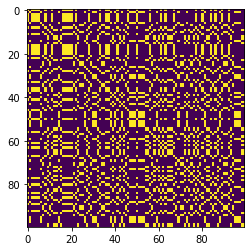

In [427]:
idx = onp.random.choice(range(X.shape[0]), 100, replace=False)
batch = X[idx]
labels = Y[idx]
y_mask = labels.dot(labels.T).astype(bool)
plt.imshow(y_mask)

In [407]:
D = 3
d = 2
A = onp.random.randn(d,D)*0.1

g_sq = np.zeros_like(A)
m = np.zeros_like(A)

mass = 1
ayze = list()
g_squares = list()
lr = 0.1 #step size
momentum=0.9

values = list()
for _ in range(300):
    idx = onp.random.choice(range(X.shape[0]), 100, replace=False)
    batch = X[idx]
    labels = Y[idx]

    #y_mask = (labels[:, None] == labels[None, :])
    y_mask = labels.dot(labels.T).astype(bool)
    zero_mask = onp.array(y_mask.sum(1)==1)
    pos_idx = (~zero_mask).nonzero()[0]

    value, g = value_and_grad(loss)(A,batch,y_mask, pos_idx)
    values.append(value)
        
    g_sq += g**2
    g_sq_inv_sqrt = np.where(g_sq > 0, 1. / np.sqrt(g_sq), 0.0)
    m = (1. - momentum) * (g * g_sq_inv_sqrt) + momentum * m
    A = A - lr * m
    print(value)
    ayze.append(A)


670.3438
660.6959
661.0021
654.6176
645.36346
641.93134
640.635
638.36163
630.3844
627.53265
618.1136
622.1969
611.9957
621.0352
623.05133
617.9376
612.86194
612.03345
603.7284
610.5867
607.72003
602.40625
593.2341
598.2604
595.25555
594.67175
593.72943
587.991
592.9795
586.6207
584.6869
584.403
572.0905
582.0427
578.76263
580.4924
588.3422
576.1742
573.8381
581.0826
581.9308
570.13043
578.64166
575.98114
573.5612
591.6453
562.6219
566.0241
559.1532
565.7353
571.1208
567.77277
580.2433
572.32385
563.5643
577.17175
564.7614
568.3597
567.0533
565.6774
564.0936
568.2951
560.0141
564.5537
556.80554
566.27747
560.29816
568.3532
561.91064
560.5061
550.2348
562.04395
565.30475
564.21875
566.08307
561.7819
562.4503
557.1721
561.04755
560.49554
564.4978
549.05835
593.9631
554.7741
563.26086
567.3608
566.94763
564.95685
573.79254
579.2516
563.8532
562.7051
563.99243
563.376
563.509
562.5455
582.9172
552.39166
582.2962
557.0812
560.22546
571.3494
579.20953
569.76465
583.13416
556.6503
564.0262
5

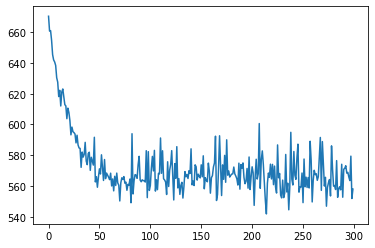

In [408]:
plt.plot(values)

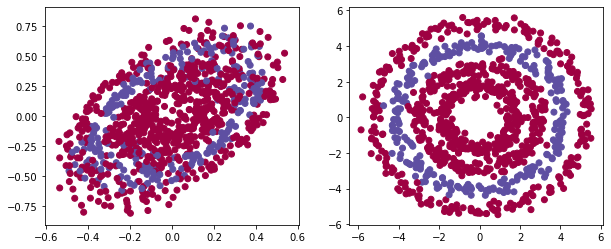

In [409]:
fig, ax = plt.subplots(1,2)
idx = 2

fig.set_figwidth(10)
emb = X.dot(ayze[0].T)
ax[0].scatter(emb[:,0], emb[:,1], c=Y[:,idx], cmap='Spectral')

emb = X.dot(ayze[-1].T)
ax[1].scatter(emb[:,0], emb[:,1], c=Y[:,idx], cmap='Spectral')

# testing on sklearn multilabel set

In [466]:
from sklearn.datasets import make_multilabel_classification
X, Y = make_multilabel_classification(n_samples=5000, n_features=4, n_classes =20)

empty_rows = Y.sum(1)==0
X = X[~empty_rows]
Y = Y[~empty_rows]

from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

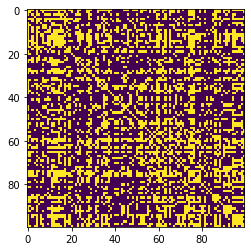

In [467]:
D = 4
d = 2
A = onp.random.randn(d,D)*0.1
idx = onp.random.choice(range(X.shape[0]), 100, replace=False)
batch = X[idx]
labels = Y[idx]
y_mask = labels.dot(labels.T).astype(bool)
plt.imshow(y_mask)


In [468]:
D = 4
d = 2
A = onp.random.randn(d,D)*0.1

g_sq = np.zeros_like(A)
m = np.zeros_like(A)

mass = 1
ayze = list()
g_squares = list()
lr = 0.1 #step size
momentum=0.9

values = list()
for _ in tqdm.tqdm_notebook(range(1000)):
    idx = onp.random.choice(range(X.shape[0]), 200, replace=False)
    batch = X[idx]
    labels = Y[idx]

    #y_mask = (labels[:, None] == labels[None, :])
    y_mask = labels.dot(labels.T).astype(bool)
    zero_mask = onp.array(y_mask.sum(1)==1)
    pos_idx = (~zero_mask).nonzero()[0]

    value, g = value_and_grad(loss)(A,batch,y_mask, pos_idx)
    values.append(value)
        
    g_sq += g**2
    g_sq_inv_sqrt = np.where(g_sq > 0, 1. / np.sqrt(g_sq), 0.0)
    m = (1. - momentum) * (g * g_sq_inv_sqrt) + momentum * m
    A = A - lr * m
    print(value)
    ayze.append(A)

<ipython-input-468-483a0567d07b>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm.tqdm_notebook(range(1000)):


1459.4419
1455.6921
1434.2765
1433.399
1419.3739
1417.4548
1406.8793
1385.935
1395.7771
1391.4628
1386.3883
1390.994
1381.635
1361.098
1369.4056
1372.6907
1335.9723
1356.7136
1352.2843
1346.393
1332.542
1342.4857
1343.0637
1355.5421
1346.9138
1343.7177
1337.0841
1343.9432
1318.0338
1349.9532
1331.7981
1332.2097
1341.5261
1355.0864
1341.3402
1344.7909
1329.7833
1343.428
1314.59
1341.1174
1323.5265
1352.0675
1346.1711
1358.6779
1351.0162
1345.1494
1351.537
1328.491
1345.6923
1330.6354
1343.0531
1349.7435
1334.8501
1328.8833
1342.9469
1347.8523
1331.7993
1351.0105
1344.7965
1328.3438
1301.8492
1330.5975
1347.5024
1342.2886
1344.3766
1332.9401
1345.9482
1367.2401
1339.5796
1351.2561
1309.8511
1344.983
1340.8787
1374.2234
1341.1576
1340.3562
1318.2502
1344.0442
1348.5682
1321.7234
1306.378
1344.1252
1362.6992
1341.4784
1335.5367
1355.0625
1323.1669
1321.7427
1337.02
1346.7351
1365.6755
1354.276
1331.0698
1356.6058
1354.8103
1348.0808
1342.3959
1334.7563
1328.897
1336.4038
1343.927
1329.1622

KeyboardInterrupt: 

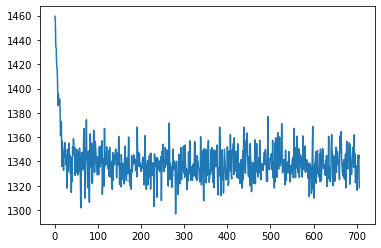

In [469]:
plt.plot(values)

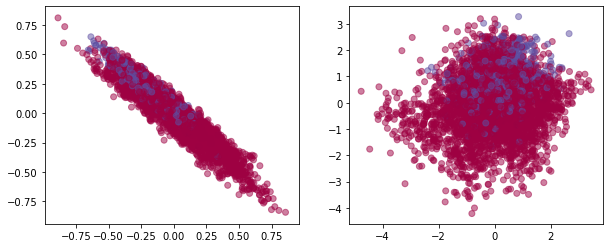

In [470]:
fig, ax = plt.subplots(1,2)
idx = 0

fig.set_figwidth(10)
emb = X.dot(ayze[0].T)
ax[0].scatter(emb[:,0], emb[:,1], c=Y[:,idx], cmap='Spectral',alpha=0.5)

emb = X.dot(ayze[-1].T)
ax[1].scatter(emb[:,0], emb[:,1], c=Y[:,idx], cmap='Spectral', alpha=0.5)

# Trying on molecules:


In [7]:
# X = x.copy().toarray()
# Y = y.copy().toarray()

X = sparse.load_npz('/Users/lmar3213/Documents/GitHub/lbvs_data_blocking/code/raw_data/x_norm_sparse.npz').toarray()
Y = sparse.load_npz('/Users/lmar3213/Documents/GitHub/lbvs_data_blocking/code/raw_data/y.npz').toarray()

target_idx = onp.arange(Y.shape[1])
onp.random.shuffle(target_idx)
onp.save('target_idx.npy', target_idx)
first_half = target_idx[:target_idx.shape[0]//2]

mask = Y[:,first_half].sum(1)!=0
Y = Y[mask]
X = X[mask]

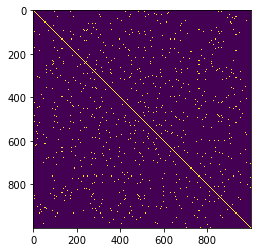

In [8]:
idx = onp.random.choice(range(X.shape[0]), 1000, replace=False)
batch = X[idx]
labels = Y[idx]
y_mask = labels.dot(labels.T).astype(bool)
plt.imshow(y_mask)

In [9]:
@jit
def loss(A, X, y_mask, zero_mask):
    embedding = X.dot(A.T)
    distances = E_fn(embedding)

    
    p_ij = softmax(-distances)
    p_ij_mask = p_ij * y_mask
    p_i = p_ij_mask.sum(1)
    loss = -p_i.sum()
    
    logprobs = np.log(p_i[zero_mask])
    clf_loss = -np.sum(logprobs)

    diff_class_distances = distances * ~y_mask
    hinge_loss = (np.clip(1- diff_class_distances, 0, np.inf)**2).sum(1).mean()
    return clf_loss + hinge_loss

In [31]:
D = 256
d = 400
A = onp.random.randn(d,D)*0.01

g_sq = np.zeros_like(A)
m = np.zeros_like(A)

mass = 1
ayze = list()
g_squares = list()
lr = 0.1 #step size
momentum=0.9

values = list()
for _ in tqdm.tqdm_notebook(range(200)):
    idx = onp.random.choice(range(X.shape[0]), 1000, replace=False)
    batch = X[idx]
    labels = Y[idx]

    #y_mask = (labels[:, None] == labels[None, :])
    y_mask = labels.dot(labels.T).astype(bool)
    zero_mask = onp.array(y_mask.sum(1)==1)
    pos_idx = (~zero_mask).nonzero()[0]

    value, g = value_and_grad(loss)(A,batch,y_mask, pos_idx)
    values.append(value)
        
    g_sq += g**2
    g_sq_inv_sqrt = np.where(g_sq > 0, 1. / np.sqrt(g_sq), 0.0)
    m = (1. - momentum) * (g * g_sq_inv_sqrt) + momentum * m
    A = A - lr * m
    print(value)
    ayze.append(A)

<ipython-input-31-f05f73dabf2c>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm.tqdm_notebook(range(200)):


10969.845
9795.481
14347.865
16406.086
18216.057
16329.272
14834.76
13322.274
11927.469
11875.628
13048.648
13863.088
12005.894
12123.322
11292.907
11249.376
10784.474
10888.539
11104.424
11454.038
10624.52
10587.802
10207.9
10260.732
10362.842
10260.979
10165.6875
10016.639
10032.219
9897.149
10094.462
9632.985
9762.501
9685.946
9727.151
9637.207
9716.239
9727.752
9744.014
9775.526
9690.257
9774.472
9601.739
9584.869
9461.167
9500.272
9528.63
9640.923
9802.235
9656.24
9573.991
9445.91
9540.592
9603.853
9515.921
9537.735
9597.889
9603.309
9591.185
9637.088
9519.922
9484.566
9492.934
9516.399
9430.618
9387.4795
9377.003
9402.788
9525.471
9519.796
9596.131
9519.741
9401.95
9496.253
9471.343
9406.242
9411.072
9341.212
9409.816
9407.673
9423.556
9361.317
9350.537
9443.957
9541.953
9315.487
9503.413
9595.624
9390.703
9341.015
9377.942
9239.121
9396.22
9507.171
9467.373
9491.22
9447.349
9549.283
9409.511
9315.502
9531.301
9366.04
9430.779
9492.345
9412.467
9574.563
9341.059
9615.844
9322.547

KeyboardInterrupt: 

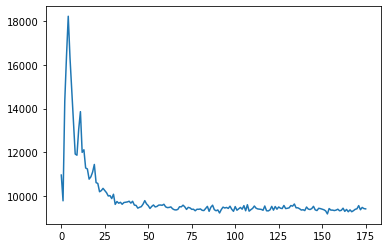

In [32]:
plt.plot(values)

In [12]:
#
#np.save('A.npy', A)

In [30]:
embedding = x_full.dot(A.T)
embedding = np.save('embedding.npy', embedding)

# Testing a nonlinear contrastive loss:

In [10]:
X = sparse.load_npz('/Users/lmar3213/Documents/GitHub/lbvs_data_blocking/code/raw_data/x_norm_sparse.npz').toarray()
Y = sparse.load_npz('/Users/lmar3213/Documents/GitHub/lbvs_data_blocking/code/raw_data/y.npz').toarray()

target_idx = onp.arange(Y.shape[1])
onp.random.shuffle(target_idx)
onp.save('target_idx.npy', target_idx)
first_half = target_idx[:target_idx.shape[0]//2]

mask = Y[:,first_half].sum(1)!=0
Y = Y[mask]
X = X[mask]

In [11]:
from jax.config import config
from jax import jit, grad, lax, random, vmap
from jax.experimental import optimizers, stax
from jax.experimental.stax import Dense, Relu, LeakyRelu, Elu
from jax.nn.initializers import he_uniform

In [91]:
###Softmax that sets distances to self to -np.inf, meaning the probability goes to zero.
@jit
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp((x - np.diag(np.ones(x.shape[0])*np.inf)) - np.max(x))
    return e_x / e_x.sum()


#E_fn is just a pairwise distance function,
#stole from https://github.com/google/jax/issues/787 .
@jit
def E_fn(conf):
    ri = np.expand_dims(conf, 0)
    rj = np.expand_dims(conf, 1)
    dxdydz = np.power(ri - rj, 2)
    #return squared euclidean:
    dij = np.sum(dxdydz, axis=-1)
    return dij
    

def plot_loss(losses):
    fig, ax = plt.subplots()
    ax.plot(losses)
    fig.savefig('loss.png')
    plt.close(fig)
    
def init_my_network(embed_dims):
    test_rng = random.PRNGKey(1)
    _, dec_init_rng = random.split(random.PRNGKey(2))
    decoder_init, decode = stax.serial(
        Dense(2048, W_init=he_uniform()), Relu,
         Dense(512, W_init=he_uniform()), Relu,
         Dense(256, W_init=he_uniform()), Relu,
         Dense(128, W_init=he_uniform()), Relu,
         Dense(64, W_init=he_uniform()), Relu,
        #worked pretty good
         Dense(128, W_init=he_uniform()), Relu, 
         Dense(256, W_init=he_uniform()), Relu, 
#         Dense(256, W_init=he_uniform()), Relu, 
        
        Dense(embed_dims, W_init=he_uniform()),)

    _, init_decoder_params =decoder_init(dec_init_rng, (-1, 256))
    #opt_init, opt_update, get_params = optimizers.adam(step_size=1e-4)
    opt_init, opt_update, get_params = optimizers.adagrad(step_size=1e-2)
    opt_state = opt_init(init_decoder_params)
    return opt_state, opt_update, decode, get_params

@jit
def loss(p, x_, y_mask, zero_mask):
    embedding = decode(p, x_)
    distances = E_fn(embedding)

    #     eps = 1e-8
#     x = embedding
#     n = np.linalg.norm(x, axis=1)
    
#     pairwise_cosine = np.clip(x.dot(x.T) / (n * n.T), a_min=eps)
#     distances = np.exp(pairwise_cosine/0.5)
    ###Seems like the traditional euclidean distance works best!
    #OR: normalized vector dot products
    #lengths = np.linalg.norm(embedding, axis=1)
    #emb_norm =(emb.T/lengths).T
    #emb_norm = emb.copy()
    #distances = -1/emb_norm.dot(emb_norm.T)
    
    p_ij = softmax(-distances)
    p_ij_mask = p_ij * y_mask
    p_i = p_ij_mask.sum(1)
    loss = -p_i.sum()
    
    logprobs = np.log(p_i[zero_mask])
    clf_loss = -np.sum(logprobs)

    diff_class_distances = distances * ~y_mask
    hinge_loss = (np.clip(1- diff_class_distances, 0, np.inf)**2).sum(1).mean()
    return clf_loss + hinge_loss


In [92]:
###Set up the network:
embed_dims = 400
batch_size = 1000
opt_state, opt_update, decode, get_params = init_my_network(embed_dims = embed_dims)



loss_list = list()

def step(i, opt_state):
    ###Selecting a batch of labels and removing bad ones:
    idx = onp.random.choice(range(X.shape[0]), batch_size, replace=False)
    #use a *10 for the normalized dot product version:
    #batch = X[idx]*10
    #use a *10 for the normalized dot product version:
    batch = X[idx]
    labels = Y[idx]
    y_mask = labels.dot(labels.T).astype(bool)
    zero_mask = onp.array(y_mask.sum(1)==1)
    pos_idx = (~zero_mask).nonzero()[0]
    
    #getting current network parameters:
    p = get_params(opt_state)   
    
    #get parameter gradients:
    v, g = value_and_grad(loss)(p, batch, y_mask, pos_idx)
    loss_list.append(v)
    print(v)
    if i%5==0:
        plot_loss(loss_list)
    return opt_update(i, g, opt_state)

for i in tqdm.tqdm_notebook(range(500)):
    opt_state= step(i, opt_state)


<ipython-input-92-2c70798a6791>:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(500)):


28824.766
12157.514
11563.313
11179.942
11196.879
11151.219
11091.865
10982.591
10890.857
10979.509
10772.135
10707.16
10579.039
10602.233
10585.91
10510.877
10388.383
10403.751
10190.72
10270.39
10158.777
10255.432
10196.123
10053.196
10058.97
9971.241
10143.382
9980.867
10035.635
10043.45
9940.743
9988.356
9744.029
9851.833
9719.233
9884.404
9872.73
9787.0625
9893.427
9753.647
9792.399
9777.515
9706.391
9638.199
9732.296
9672.625
9702.161
9588.177
9602.665
9638.432
9564.119
9590.6875
9512.906
9603.618
9520.964
9524.423
9385.028
9591.13
9462.322
9554.952
9488.728
9550.23
9484.554
9479.458
9440.6045
9534.184
9482.45
9335.858
9460.502
9394.874
9439.336
9360.204
9485.076
9370.14
9354.732
9340.039
9314.811
9221.481
9272.339
9358.806
9304.329
9374.691
9352.216
9121.225
9296.562
9339.154
9352.948
9359.52
9299.057
9249.388
9152.835
9281.762
9344.421
9257.376
9197.845
9195.072
9185.143
9314.541
9171.962
9225.51
9166.907
9248.99
9104.23
9183.952
9033.91
9211.286
9103.253
9084.005
9110.489
9185

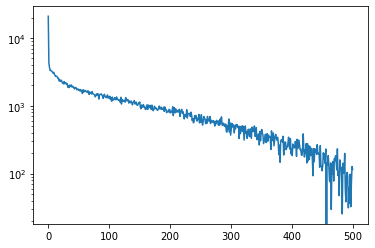

In [101]:
plt.plot(np.array(loss_list) - min(loss_list))
plt.yscale('log')

In [102]:
p = get_params(opt_state)
emb = decode(p, batch)

In [23]:
n = np.linalg.norm(emb, axis=1)

In [74]:
eps = 1e-8
x = emb.copy()
pairwise_cosine = np.clip(x.dot(x.T) / (n * n.T), a_min=eps)
xexp = np.exp(pairwise_cosine/0.5)
out = np.diag(xexp) / (xexp.sum(0) - np.exp(1/0.5))

In [78]:
xexp

DeviceArray([[7.389056 , 2.54829  , 2.0901406, ..., 2.3991342, 2.224106 ,
              2.0507271],
             [2.6221783, 7.389056 , 2.12776  , ..., 2.3077583, 2.5525453,
              2.1887605],
             [4.2299633, 4.1924844, 7.389058 , ..., 3.196281 , 3.237155 ,
              2.7744029],
             ...,
             [2.7691913, 2.5715237, 1.996431 , ..., 7.3890553, 1.9138935,
              3.0397472],
             [3.3846328, 4.0026326, 2.4990695, ..., 2.34124  , 7.3890553,
              2.5337434],
             [2.4357755, 2.5656772, 1.9090607, ..., 3.26759  , 2.128799 ,
              7.3890533]], dtype=float32)

In [72]:

out = np.diag(xexp) / (xexp.sum(0) - np.exp(1/0.5))

In [73]:
out.sum()

DeviceArray(3.107316, dtype=float32)

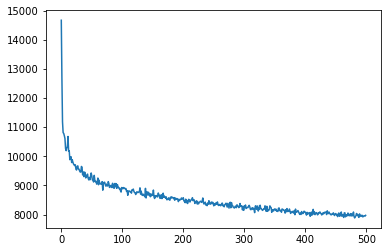

In [191]:
plt.plot(loss_list)

In [103]:
x_full = sparse.load_npz('/Users/lmar3213/Documents/GitHub/lbvs_data_blocking/code/raw_data/x_norm_sparse.npz').toarray()
p = get_params(opt_state)  
embedding = decode(p, x_full)

In [104]:
np.save('embedding.npy', embedding)

In [19]:
!pwd

/Users/lmar3213/Documents/GitHub/nca_jax


In [175]:
emb = decode(p, batch)
distances = E_fn(emb)

In [178]:

linal = np.linalg.norm(emb, axis=1)
emb_norm =(emb.T/linal).T
tdistances = emb_norm.dot(emb_norm.T)

In [179]:
tdistances

DeviceArray([[0.99999976, 0.74999887, 0.76123255, ..., 0.7563629 ,
              0.66751677, 0.7688525 ],
             [0.74999887, 0.9999997 , 0.7036865 , ..., 0.7791331 ,
              0.7126986 , 0.76763886],
             [0.76123255, 0.7036865 , 0.9999998 , ..., 0.7073661 ,
              0.6055904 , 0.81234264],
             ...,
             [0.7563629 , 0.7791331 , 0.70736617, ..., 1.0000001 ,
              0.7966421 , 0.7888763 ],
             [0.6675167 , 0.7126986 , 0.6055904 , ..., 0.7966421 ,
              1.0000001 , 0.7650386 ],
             [0.76885235, 0.7676388 , 0.8123425 , ..., 0.7888763 ,
              0.7650386 , 0.99999994]], dtype=float32)

In [152]:
softmax(-emb.dot(emb.T)).sum()

DeviceArray(1.0000001, dtype=float32)

In [62]:
p_ij = softmax(-tdistances)

In [139]:
embt = emb/100



In [153]:
softmax(-embt.dot(embt.T))

DeviceArray([[0.0000000e+00, 1.0048924e-06, 9.7835721e-07, ...,
              9.1356327e-07, 1.2406878e-06, 1.0336106e-06],
             [1.0048924e-06, 0.0000000e+00, 9.9221188e-07, ...,
              9.3361217e-07, 1.2422532e-06, 1.0367572e-06],
             [9.7835721e-07, 9.9221188e-07, 0.0000000e+00, ...,
              9.1745153e-07, 1.2246680e-06, 1.0466715e-06],
             ...,
             [9.1356310e-07, 9.3361217e-07, 9.1745153e-07, ...,
              0.0000000e+00, 1.1589192e-06, 9.2141823e-07],
             [1.2406877e-06, 1.2422532e-06, 1.2246682e-06, ...,
              1.1589192e-06, 0.0000000e+00, 1.2148168e-06],
             [1.0336106e-06, 1.0367572e-06, 1.0466715e-06, ...,
              9.2141823e-07, 1.2148168e-06, 0.0000000e+00]],            dtype=float32)

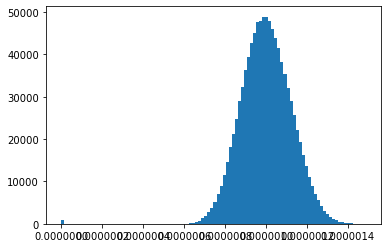

In [154]:
_ =plt.hist(softmax(-embt.dot(embt.T)).flatten(), bins=100)

In [118]:
p_ij = softmax(-emb.dot(emb.T))

In [119]:
p_ij

DeviceArray([[0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             ...,
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.],
             [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

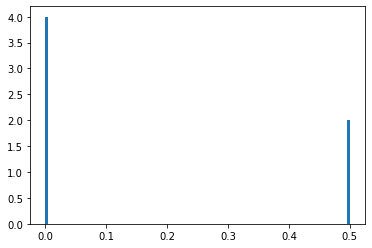

In [142]:
_=plt.hist(p_ij[p_ij>0],bins=100)

In [73]:
p_ij.sum()

DeviceArray(0.99999946, dtype=float32)

# Trying the metric-learn approach

In [4]:
import metric_learn
sdml = metric_learn.SDML_Supervised(sparsity_param=0.1, balance_param=0.0015,
                                    prior='covariance')
# X_sdml = sdml.fit_transform(X, y)

# plot_tsne(X_sdml, y)

In [5]:
X_sdml = sdml.fit_transform(X, Y)

/Users/lmar3213/miniconda3/envs/lew_jax/lib/python3.8/site-packages/metric_learn/sdml.py:369: ChangedBehaviorWarning: As of v0.5.0, `SDML_Supervised` now uses the `random_state` given at initialization to sample constraints, not the default `np.random` from the `fit` method, since this argument is now deprecated. This warning will disappear in v0.6.0.
  warnings.warn('As of v0.5.0, `SDML_Supervised` now uses the '


ValueError: bad input shape (143466, 243)